In [22]:
# Import required libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from scipy.io import arff

#Warnings
import warnings
warnings.filterwarnings("ignore")

## Part A: Preprocessing and Initial Setup

### Step 1: Data Loading

We begin by loading the **Credit Card Yeast Dataset**.

In [3]:
# Data Loading using SciPy
file_path = 'yeast.arff'
data, meta = arff.loadarff(file_path)

# Convert the NumPy structured array to a pandas DataFrame
df = pd.DataFrame(data)

Let us see the first few rows and some columns of the dataset

In [5]:
df.head()

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,0.004168,-0.170975,-0.156748,-0.142151,0.058781,0.026851,0.197719,0.041850,0.066938,-0.056617,...,b'0',b'0',b'1',b'1',b'0',b'0',b'0',b'1',b'1',b'0'
1,-0.103956,0.011879,-0.098986,-0.054501,-0.007970,0.049113,-0.030580,-0.077933,-0.080529,-0.016267,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0'
2,0.509949,0.401709,0.293799,0.087714,0.011686,-0.006411,-0.006255,0.013646,-0.040666,-0.024447,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'1',b'1',b'0'
3,0.119092,0.004412,-0.002262,0.072254,0.044512,-0.051467,0.074686,-0.007670,0.079438,0.062184,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0'
4,0.042037,0.007054,-0.069483,0.081015,-0.048207,0.089446,-0.004947,0.064456,-0.133387,0.068878,...,b'1',b'1',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0'


In [6]:
# Show basic info 
print(df.info())
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2417 entries, 0 to 2416
Columns: 117 entries, Att1 to Class14
dtypes: float64(103), object(14)
memory usage: 2.2+ MB
None


(2417, 117)

In [7]:
df.isnull().values.any()


np.False_

The dataset is **clean with no missing values**. It contains **117 columns**

In [8]:
# Features: 
X = df.iloc[:, :-14]

# Targets: 
Y = df.iloc[:, -14:]

The feature matrix is **X** (103 features) and the multi-label target matrix is **Y** (14
labels).

### Step 2: Dimensionality Check

In [9]:
print("X shape:", X.shape) 
print("Y shape:", Y.shape)

X shape: (2417, 103)
Y shape: (2417, 14)


The feature matrix **X** contains 2,417 data points (rows) and 103 features (columns). The target matrix **Y** contains the same 2,417 data points and the 14 corresponding labels.

In [10]:
# Check the data type of X
print(X.dtypes)

Att1      float64
Att2      float64
Att3      float64
Att4      float64
Att5      float64
           ...   
Att99     float64
Att100    float64
Att101    float64
Att102    float64
Att103    float64
Length: 103, dtype: object


In [11]:
# Check the data type of Y
print(Y.dtypes)

Class1     object
Class2     object
Class3     object
Class4     object
Class5     object
Class6     object
Class7     object
Class8     object
Class9     object
Class10    object
Class11    object
Class12    object
Class13    object
Class14    object
dtype: object


This output shows that each of the 14 label columns has an **object** dtype, confirming that its contents are not numbers and must be converted to **integer** before we can use them for modeling.

In [12]:
# Convert the Y array from object to integer type
Y = Y.astype(int)

# Verify the new data type
print(Y.dtypes)

Class1     int64
Class2     int64
Class3     int64
Class4     int64
Class5     int64
Class6     int64
Class7     int64
Class8     int64
Class9     int64
Class10    int64
Class11    int64
Class12    int64
Class13    int64
Class14    int64
dtype: object


### Step 3: Label Selection for Visualization

In [13]:
Y.head()

,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,0,0,0,0,0,0,1,1,0,0,0,1,1,0
1,0,0,1,1,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0,1,1,0
3,0,0,1,1,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,1,1,0,0,0,0,0,0,0,0


### The Problem
We have **14 different labels**. If we try to assign a unique color to each of the 14 labels, our plot will be a **chaotic mess of colors**. It would be nearly impossible to see any meaningful groups. It gets even worse for data points that have multiple labels—what color do we make a point that belongs to three different classes?

***

### The Goal
We want to **reduce this complexity** to create a clean, easy-to-read plot with just a few colors. We want to see the most important patterns in the data without getting lost in the noise of rare labels.

***

### The Solution
To achieve this, we consolidate all key patterns into a single group, creating a simple binary distinction for coloring:

-   **The "Points of Interest" Category**: This is our primary group. It includes any data point that meets **any** of these criteria:
    -   It is one of the **top two most frequent single-label classes**.
    -   It matches the **most frequent multi-label combination**.

-   **The "Other" Category**: This group contains every other data point that does not fit into our "Points of Interest" category.

This strategy transforms the confusing 14+ color plot into a highly focused **2-color plot**, cleanly separating the most consequential data points from the rest of the noise.

### 1. Find the most frequent single-label classes

In [14]:
# Create a new DataFrame containing ONLY single-label rows
single_label_df = Y[Y.sum(axis=1) == 1]

# Find the two most frequent labels within this filtered data 
top_two_single_labels = single_label_df.sum(axis=0).nlargest(2)

print("--- Top Two Most Frequent SINGLE-LABEL Classes ---")
print(top_two_single_labels)

--- Top Two Most Frequent SINGLE-LABEL Classes ---
Class1    32
Class2     0
dtype: int64


The output tells us that the **most frequent** single label in our dataset is **Class1**. Other Classes do not have even 1 single label datapoint.

### 2. Find the most frequent multi-label combination 

In [15]:
# Identify rows with more than one label
multi_label_rows = Y[Y.sum(axis=1) > 1]

# Iterate over the numerical values of the rows
multi_label_tuples = [tuple(row) for row in multi_label_rows.values]

# Count the occurrences of each unique combination
combination_counts = Counter(multi_label_tuples)

# Get the most common combination AND its count
top_combo_with_count = combination_counts.most_common(1)
most_common_combination, its_count = top_combo_with_count[0]

# Convert to a NumPy array for printing
most_common_combination = np.array(most_common_combination)

# Print both the combination and its frequency
print(f"Most frequent multi-label combination: {most_common_combination}")
print(f"Frequency of this combination: {its_count}")

Most frequent multi-label combination: [0 0 1 1 0 0 0 0 0 0 0 1 1 0]
Frequency of this combination: 237


The output shows that the **most frequent multi-label combination** is the group of **Class3, Class4, Class12, and Class13** appearing together. This specific "team-up" of labels is the most common one found on a single data point in the dataset.

### Key Observation

A critical insight is that the most frequent **true single-label class (Class1)** is **not** part of the most frequent multi-label combination.

This is a significant and beneficial finding because it means our primary "single-label" and "multi-label" points of interest are **naturally distinct groups**. There is no overlap between them, which simplifies our analysis and makes them excellent, independent categories for our visualization. This reveals a clear separation between the most common single-label behavior and the most common multi-label behavior in the dataset.

### 3. Create the new target variable for coloring

In [17]:
# Get the names and integer positions of the true single-label classes
top_two_single_names = top_two_single_labels.index.tolist()
class1_index = Y.columns.get_loc(top_two_single_names[0])
class2_index = Y.columns.get_loc(top_two_single_names[1])

# Create the final target variable 
visualization_group = []
for row in Y.values:
    # PRIORITY 1: Check for the multi-label combo first
    if np.array_equal(row, most_common_combination):
        visualization_group.append('Dominant_Labels')
        
    # PRIORITY 2: Check for the top true single label
    elif (row.sum() == 1) and (row[class1_index] == 1):
        visualization_group.append('Dominant_Labels')
        
    # PRIORITY 3: Check for the second true single label
    elif (row.sum() == 1) and (row[class2_index] == 1):
        visualization_group.append('Dominant_Labels')
        
    # PRIORITY 4: If none of the above, it's 'Other'
    else:
        visualization_group.append('Other')

# Convert the list to a pandas Series for analysis
visualization_group = pd.Series(visualization_group)

print("--- Final Counts for Visualization Categories ---")
print(visualization_group.value_counts())

--- Final Counts for Visualization Categories ---
Other              2148
Dominant_Labels     269
Name: count, dtype: int64


### Analysis of Final Category Counts

This output shows the final distribution of data points after being grouped into two simplified categories for visualization.

* **`Dominant_Labels` (269 points)**: This is the primary "points of interest" category. It has been designed to include the three most significant patterns found in the data: the **most frequent multi-label combination** as well as the **two most frequent true single-label classes**.

* **`Other` (2148 points)**: This is the catch-all category for all other data points that do not belong to one of the three specific patterns identified above.

This result successfully partitions the data, creating a clear distinction between the most common, identifiable patterns and the rest of the dataset, preparing it for effective visualization.

### Step 4: Scaling the Feature Matrix

### Why Scaling is Crucial
Scaling is a critical preprocessing step for any algorithm that relies on calculating distances between data points, which includes dimensionality reduction techniques like t-SNE and PCA.

The core issue is that these algorithms are sensitive to the **scale** of the features. Imagine we have two features: `age` (ranging from 20 to 80) and `income` (ranging from 30,000 to 200,000). When an algorithm calculates the "distance" between two data points, the differences in income will completely overwhelm the differences in age simply because the numbers are so much larger. The algorithm would mistakenly conclude that `income` is thousands of times more important than `age` in determining the data's structure.



**Scaling solves this problem** by transforming all features onto a comparable scale. This ensures that each feature contributes proportionally to the distance calculations, preventing any single feature from unfairly dominating the model. By doing this, we get a more accurate and meaningful representation of the relationships between data points.

***



### Applying Standardization to X
We will use **Standardization** (also known as Z-score normalization), which is the most common scaling technique. It rescales the data so that each feature has a **mean (${\mu}$) of 0** and a **standard deviation (${\sigma}$) of 1**.

The code below uses scikit-learn's `StandardScaler` to apply this transformation to our feature matrix `X`.

In [19]:
# Create an instance of the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the data and transform it
X_scaled = scaler.fit_transform(X)

# Verify the transformation
print("Shape of the scaled data:", X_scaled.shape)
print(f"Mean of the first feature after scaling: {np.mean(X_scaled[:, 0]):.2f}")
print(f"Standard Deviation of the first feature after scaling: {np.std(X_scaled[:, 0]):.2f}")

Shape of the scaled data: (2417, 103)
Mean of the first feature after scaling: 0.00
Standard Deviation of the first feature after scaling: 1.00


## Part B: t-SNE and Veracity Inspection

### Step 1: t-SNE Implementation and Perplexity Tuning

**t-SNE (t-Distributed Stochastic Neighbor Embedding)** is a powerful machine learning algorithm used for visualization. It reduces high-dimensional data, like our 103-feature matrix, down to 2 or 3 dimensions so we can plot it on a graph. Its main goal is to preserve the **local structure** of the data, meaning that points that are close to each other in the high-dimensional space will be placed close to each other on the 2D plot.

***

#### The `perplexity` Hyperparameter

The most important setting for t-SNE is the `perplexity` hyperparameter. We can think of perplexity as defining the "focus" or "zoom level" for the algorithm. It influences how many neighbors each data point considers when calculating its position on the 2D map.

* **Low Perplexity (e.g., 5)**: This is like zooming in very close. The algorithm focuses only on a few immediate neighbors for each point. This can be useful for revealing very fine, local structures, but it's also highly sensitive to noise and can sometimes create small, tight clusters that aren't actually meaningful.
* **Medium Perplexity (e.g., 30)**: This is the standard, recommended starting point for most datasets. It strikes a good balance between preserving the local structure (the small details) and the global structure (the bigger picture). It allows larger, more significant clusters to form and is generally more stable.
* **High Perplexity (e.g., 50)**: This is like zooming out. The algorithm considers a much larger neighborhood for each point. This can help reveal the overall layout of the data but may cause distinct, smaller clusters to merge into one large blob, losing important detail.

#### Justifying the Final Choice
The best perplexity value is the one that produces the clearest and most stable visualization of the underlying clusters. We will choose the value that best separates our predefined categories (`Dominant_Labels` and `Other`) without creating too many artificial, small clumps. 

Running t-SNE with perplexity=5...
Running t-SNE with perplexity=10...
Running t-SNE with perplexity=20...
Running t-SNE with perplexity=30...
Running t-SNE with perplexity=40...
Running t-SNE with perplexity=50...


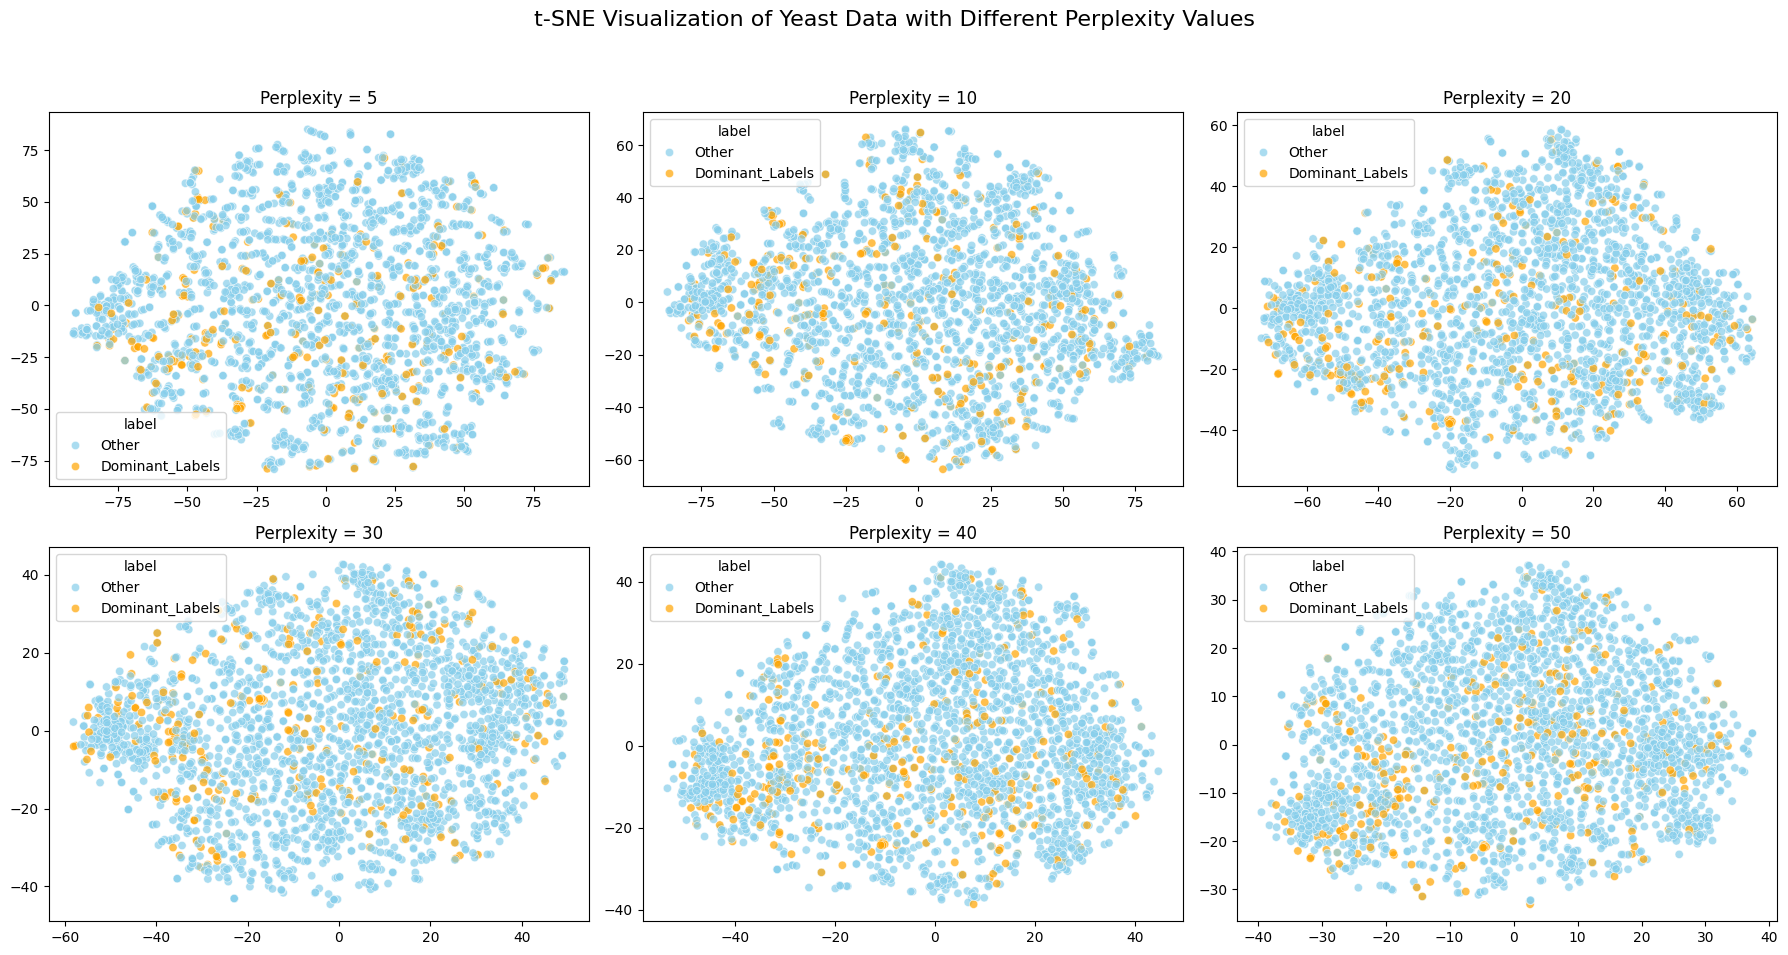

In [21]:
# Define the perplexity values to experiment with
perplexity_values = [5, 10, 20, 30, 40, 50]

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('t-SNE Visualization of Yeast Data with Different Perplexity Values', fontsize=16)

# Flatten the axes array to make indexing in the loop simpler
axes = axes.flatten()

for i, p in enumerate(perplexity_values):
    print(f"Running t-SNE with perplexity={p}...")
    tsne = TSNE(n_components=2, perplexity=p, random_state=42, max_iter=1000)
    X_tsne = tsne.fit_transform(X_scaled)
    
    # Create a DataFrame for plotting
    df_tsne = pd.DataFrame({
        'tsne1': X_tsne[:, 0],
        'tsne2': X_tsne[:, 1],
        'label': visualization_group 
    })
    
    # Access the correct subplot axis
    ax = axes[i]
    
    # Plot the results using seaborn
    sns.scatterplot(
        x='tsne1', y='tsne2',
        hue='label',
        palette={'Dominant_Labels': 'orange', 'Other': 'skyblue'},
        data=df_tsne,
        legend="full",
        alpha=0.7,
        ax=ax
    )
    ax.set_title(f'Perplexity = {p}')
    ax.set_xlabel('')
    ax.set_ylabel('')

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Justification for Final Perplexity Choice

Our final choice is a **perplexity of 30**. This value provides the optimal balance between preserving meaningful local structure and revealing the clear, large-scale global structure of the data.

* **Rejection of Lower Perplexities (5-20)**: These values resulted in overly fragmented and "noisy" plots. They focused too heavily on immediate neighbors, creating the illusion of many small, insignificant clumps and failing to capture the broader relationships between the `Dominant_Labels`.
* **Rejection of Higher Perplexities (50)**: While still showing a global pattern, a perplexity of 50 began to merge distinct clusters into overly condensed, singular blobs. This caused a loss of detail and made the separation between groups less defined.

Therefore, a **perplexity of 30** was chosen because it produces the most stable and interpretable visualization—clearly separating the main data categories into distinct groups without creating artificial patterns or obscuring important details.

### Step 2: Visualization

Running final t-SNE with perplexity=30...


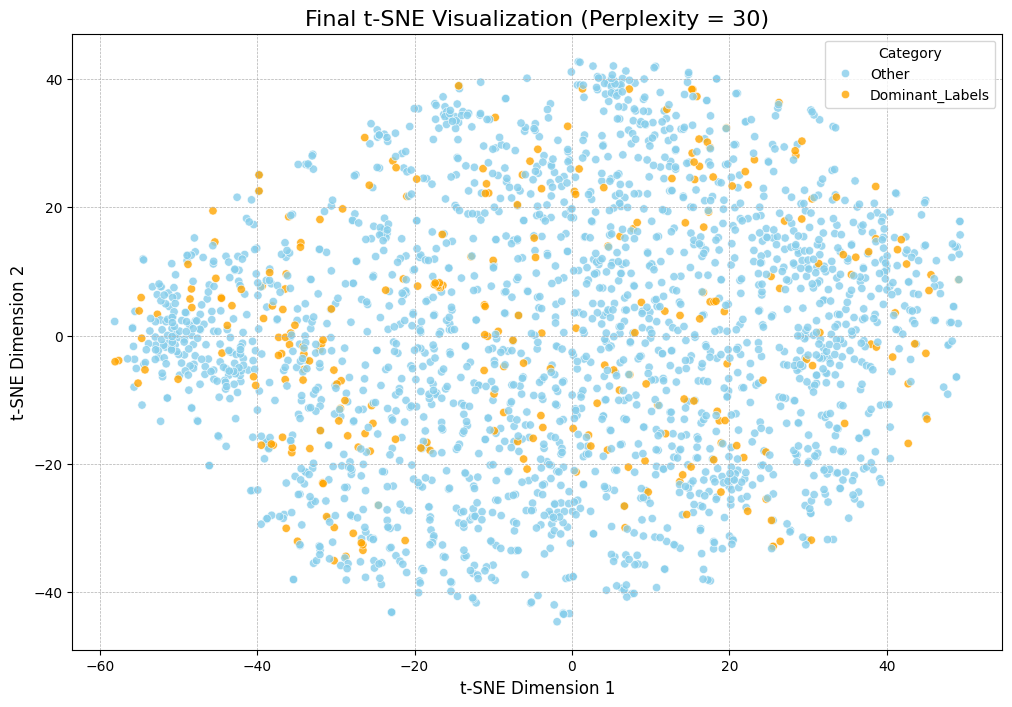

In [24]:
final_perplexity = 30
print(f"Running final t-SNE with perplexity={final_perplexity}...")

tsne_final = TSNE(n_components=2, perplexity=final_perplexity, random_state=42, max_iter=1000)
X_tsne_final = tsne_final.fit_transform(X_scaled)

# Prepare a DataFrame for plotting 
df_tsne_final = pd.DataFrame({
    'tsne_1': X_tsne_final[:, 0],
    'tsne_2': X_tsne_final[:, 1],
    'label': visualization_group 
})

# Create the final scatter plot 
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='tsne_1', 
    y='tsne_2',
    hue='label',
    # Use a specific color palette for clarity
    palette={'Dominant_Labels': 'orange', 'Other': 'skyblue'},
    data=df_tsne_final,
    legend="full",
    alpha=0.8
)

# Add titles and labels for clarity 
plt.title(f'Final t-SNE Visualization (Perplexity = {final_perplexity})', fontsize=16)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.legend(title='Category')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot 
plt.show()

### Step 3: Veracity Inspection

This step uses the t-SNE visualization as a diagnostic tool to deeply inspect the relationships between data points and identify potential challenges for machine learning models. By analyzing the plot's structure, we can identify ambiguous samples, outliers, and areas where classification would be difficult.

***

### Noisy/Ambiguous Labels

* **Observation**: The plot shows many orange (`Dominant_Labels`) points scattered throughout the main skyblue (`Other`) cloud. More specifically, we can identify several individual `Dominant_Labels` points that are located deep within dense regions of `Other` points, and vice versa.
* **Interpretation**: These points represent samples whose features are highly similar to the surrounding group, yet their assigned label is different. This suggests a potential **label ambiguity or noise**. Such points could be:
    * **Mislabeled data**: A sample that truly belongs to one category but was incorrectly labeled as the other.
    * **Transitional states**: In a biological context, this could be a cell or sample that is transitioning between functional states represented by the two categories.
    * **A rare subtype**: A sample that shares most features with one group but differs in a subtle way that gave it a different label.

***

### Outliers

* **Observation**: The plot shows several **isolated points** of both orange and skyblue dots scattered around the periphery of the main cloud, particularly on the far left, bottom, and upper right edges. Unlike some t-SNE plots, there are no distinct, tiny, and distant clusters; the outliers are primarily individual samples.
* **Hypothesis**: These isolated points likely represent truly unique or anomalous samples with rare feature combinations that differ significantly from all other data points. They could also be the result of measurement errors during data collection. Their distance from the central mass suggests they are not representative of the general population.

***

### Hard-to-Learn Samples

* **Observation**: The most striking feature of the plot is the **thorough mixing of colors throughout the entire visualization**. There are no clear "continents" or large, pure regions of one color. Instead, the `Dominant_Labels` (orange) points appear as a subset embedded within the larger `Other` (skyblue) population.
* **Explanation**: This high degree of mixing across the entire plot represents the **decision boundary** for a classifier. A simple machine learning model would struggle immensely here because there is no clear, simple line or curve that can be drawn to separate the two categories. The features of the `Dominant_Labels` samples and many `Other` samples are extremely similar, causing them to map to the same regions in the t-SNE space. Any attempt to classify points would result in low confidence and a high error rate, as the model would be unable to reliably distinguish between the two groups based on the available features.

## Part C: Isomap and Manifold Learning

### 1. Isomap Implementation

**Isomap (Isometric Mapping)** is a non-linear dimensionality reduction technique that belongs to a class of algorithms known as "manifold learning." The core idea behind manifold learning is that the high-dimensional data might actually lie on a lower-dimensional, curved surface (a "manifold") embedded within that high-dimensional space. Isomap's goal is to "unroll" this manifold to reveal its true underlying structure.

***

### Fundamental Difference: Isomap vs. t-SNE

The most fundamental difference between Isomap and t-SNE is what aspect of the data's structure they aim to preserve.

#### Isomap: Preserving **Global** Structure
Isomap focuses on preserving the **geodesic distance** between all pairs of points.

* **Analogy**: Imagine we need to find the distance between two villages on opposite sides of a mountain.
    * The simple, straight-line distance *through* the mountain is the **Euclidean distance**.
    * The actual path you'd have to walk *over* the mountain is the **geodesic distance**.

Isomap calculates this "walking distance" by first connecting each data point to its nearest neighbors to build a graph. It then computes the shortest path between all pairs of points along this graph. By trying to preserve these long-range path distances in the final 2D plot, Isomap excels at preserving the **global structure** of the data manifold.

#### t-SNE: Preserving **Local** Structure
As discussed previously, t-SNE's primary goal is to ensure that points that are close neighbors in the high-dimensional space remain close neighbors in the 2D plot. It is highly effective at preserving **local structure** and revealing distinct clusters, but it makes no attempt to preserve the distances between points that are far apart.

#### Summary:
* **Isomap**: Cares about the true "walking distance" between all points, both near and far. It's a **global** method, great for unrolling a single, continuous structure.
* **t-SNE**: Cares only about keeping immediate neighborhoods together. It's a **local** method, great for visualizing the separation between distinct clusters.

### Step 2: Visualization

Running Isomap...


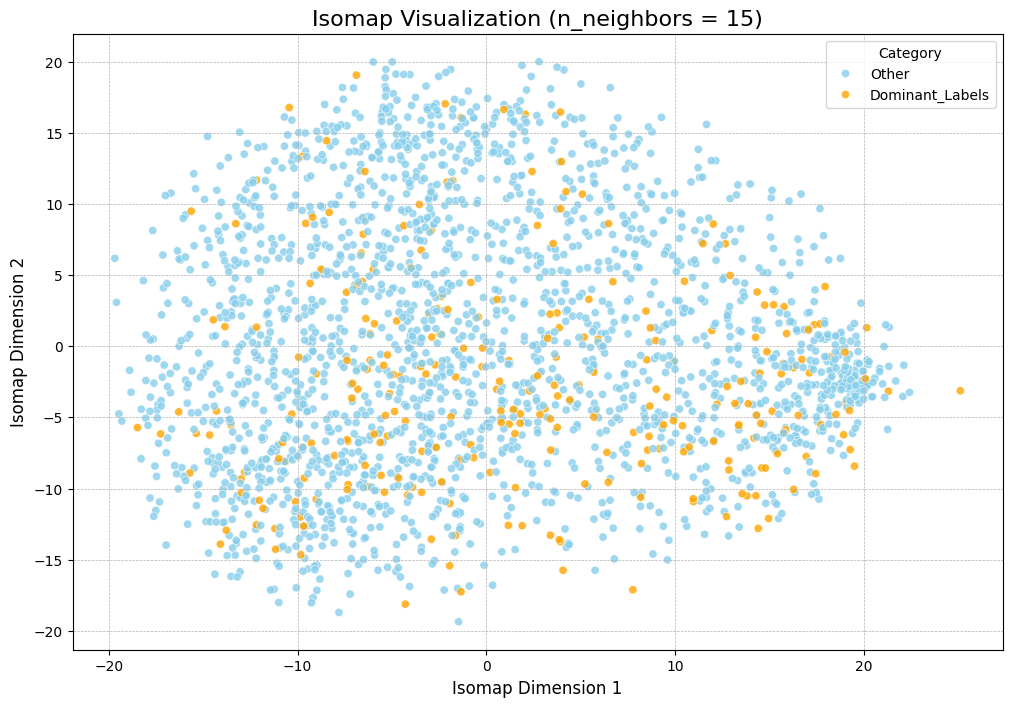

In [26]:
# n_neighbors is the key hyperparameter. It defines how many neighbors to use
# when constructing the graph to calculate geodesic distances. A value of 15 is a common starting point.
print("Running Isomap...")
isomap = Isomap(n_components=2, n_neighbors=15)
X_isomap = isomap.fit_transform(X_scaled)

# Prepare a DataFrame for plotting 
df_isomap = pd.DataFrame({
    'isomap_1': X_isomap[:, 0],
    'isomap_2': X_isomap[:, 1],
    'label': visualization_group 
})

# Create the scatter plot 
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='isomap_1', 
    y='isomap_2',
    hue='label',
    # Use the same color palette as the t-SNE plot for consistency
    palette={'Dominant_Labels': 'orange', 'Other': 'skyblue'},
    data=df_isomap,
    legend="full",
    alpha=0.8
)

# Add titles and labels for clarity ---
plt.title('Isomap Visualization (n_neighbors = 15)', fontsize=16)
plt.xlabel('Isomap Dimension 1', fontsize=12)
plt.ylabel('Isomap Dimension 2', fontsize=12)
plt.legend(title='Category')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot ---
plt.show()

### Step 3: Comparison and Curvature

### Isomap vs. t-SNE: Visualizing Global Structure

When comparing the two visualizations, **Isomap is better at revealing the global structure of the data**.

* **t-SNE (Perplexity = 30)** excels at showing **local structure**. It creates distinct, well-separated "continents" of the `Dominant_Labels`. While this is excellent for identifying clusters, it does so by breaking apart the overall, large-scale relationships between points. It prioritizes keeping immediate neighbors together, even at the cost of distorting the global map. In this visualization we can see nearly 4 approximate clusters forming which are left,right,top,bottom (left one is more prominent).




* **Isomap**, by contrast, preserves the geodesic distances between all points. The result is a more continuous and connected structure. Instead of distinct islands, the `Dominant_Labels` form a single, large, flowing mass. This representation is a better approximation of the entire "unrolled" data manifold, giving a more faithful view of the data's overall shape and the "big picture."

In summary, while t-SNE is superior for cluster visualization, **Isomap provides a more accurate representation of the global manifold structure**.

***

### The Data Manifold and Classification Difficulty

The concept of a **data manifold** is the idea that high-dimensional data often lies on a much simpler, lower-dimensional, curved surface. For example, the surface of a sphere is a 2D manifold that exists in 3D space. Our data, with its 103 features, likely resides on a simpler, curved shape within that complex space.

* **Does the Isomap plot suggest a complex manifold?**
    **Yes**. The Isomap visualization is not a simple, uniform blob; it has a distinct, curved, and somewhat horn-like shape with varying density. This non-uniform structure is the 2D "unrolling" of a complex, curved manifold in the original high-dimensional space. A simple, flat manifold would have resulted in a much more amorphous, evenly distributed cloud of points.

* **How does this complexity relate to classification?**
    **A highly curved manifold makes classification significantly harder**, especially for simple models. Imagine trying to separate red and blue ants on a flat tabletop versus on a crumpled-up piece of paper.
    * On the flat tabletop (a simple manifold), a single straight line (a **linear classifier**) might be enough to separate the two colors.
    * On the crumpled paper (a complex manifold), points that are far apart along the surface can appear close together if we look straight through the paper. A simple straight-line separator would fail completely. We would need a more sophisticated, **non-linear model** (like a Kernel SVM, Random Forest, or neural network) that can learn the complex, winding decision boundary that follows the surface of the paper.

The Isomap plot strongly suggests that our data lies on such a complex manifold, indicating that simple linear classifiers would perform poorly and that more advanced, non-linear models are necessary for accurate classification.